(1024, 1024, 35, 7)


0.41921922135904516


(0, 4)


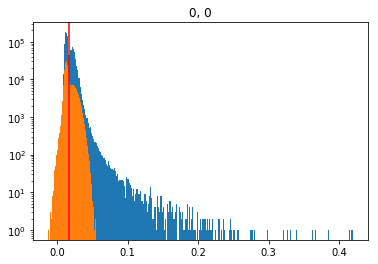

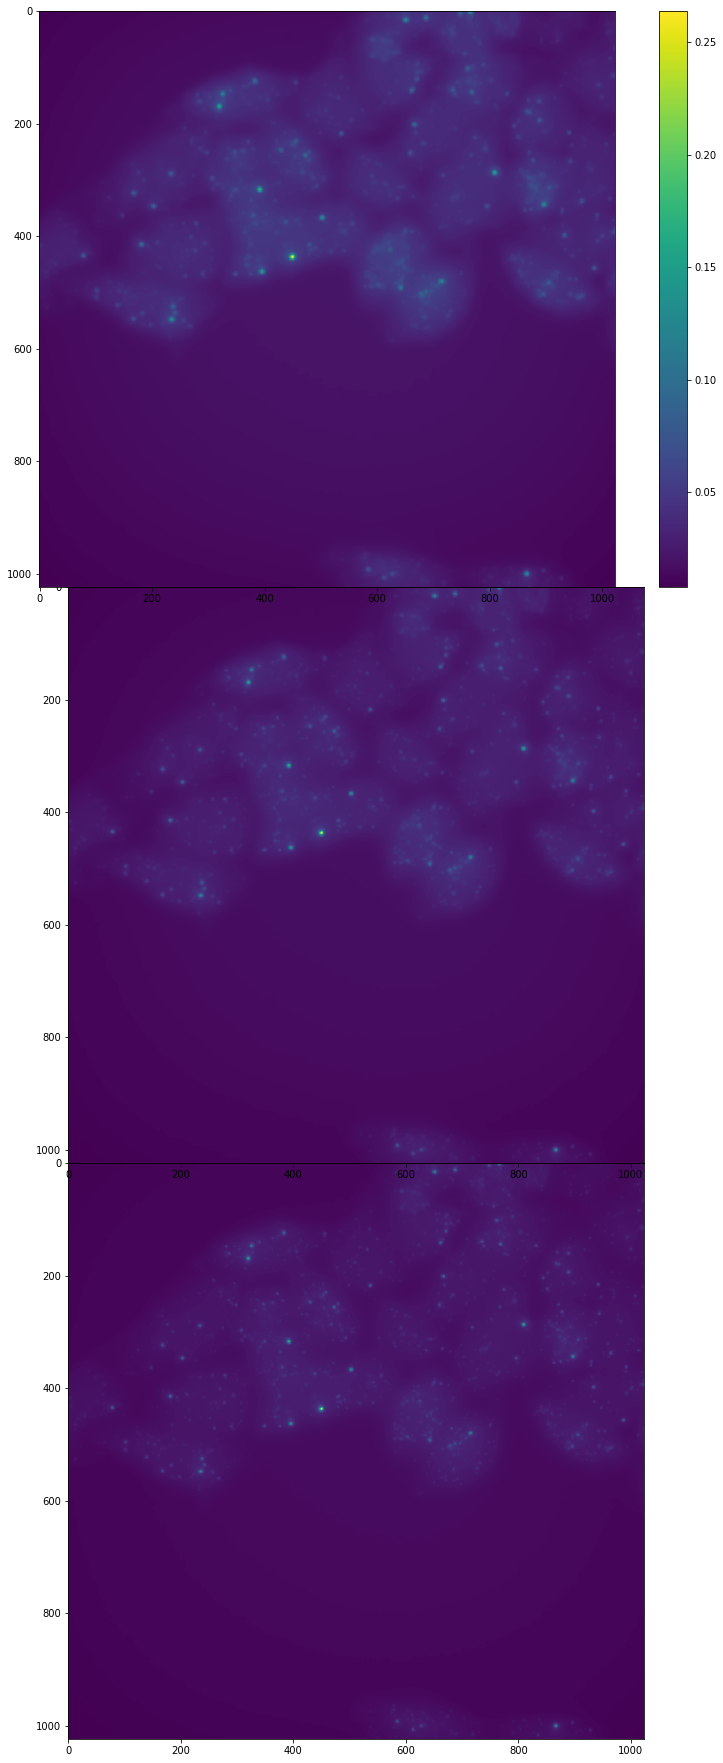

In [89]:
%matplotlib inline
from FishAnalyser import *

im_path = '/Users/remydubois/Desktop/Remy/_REMY/Opera_WF/3D/B09_DYNC1H1/r02c09f05-ch1sk1fk1fl1.tif'

im = FQimage()
im.load(im_path)


In [3]:
raw = im.image_raw.copy()

raw = img_as_float(raw)

k = int(log(float(4) / 1, 1.3)) + 1

# a geometric progression of standard deviations for gaussian kernels
sigma_list = numpy.array([1 * (1.3 ** i)
                          for i in range(k + 1)])

gaussian_images = [gaussian_filter(raw, s) for s in sigma_list]
dog_images = [(gaussian_images[i] - gaussian_images[i + 1])
              * sigma_list[i] for i in range(k)]


/Users/remydubois/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


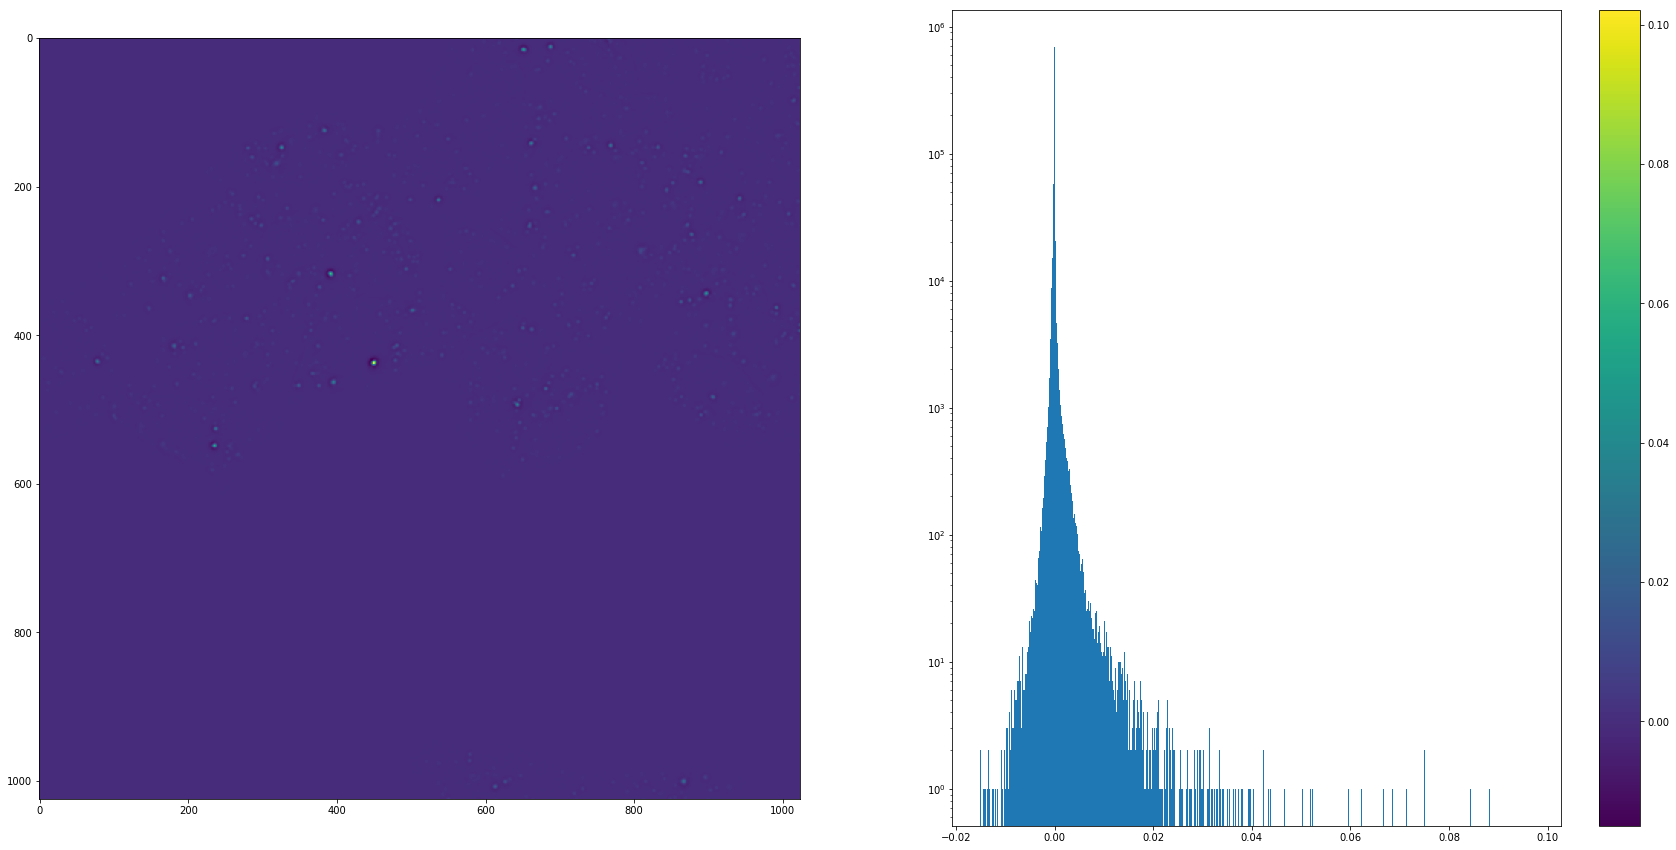

In [5]:
view = dog_images[2][:, :, 15]
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(30, 15))
a = ax.imshow(view)
f.colorbar(a)
ax2.hist(numpy.log1p(view.ravel()), bins=1000)
ax2.set_yscale('log')
f.show()

/Users/remydubois/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


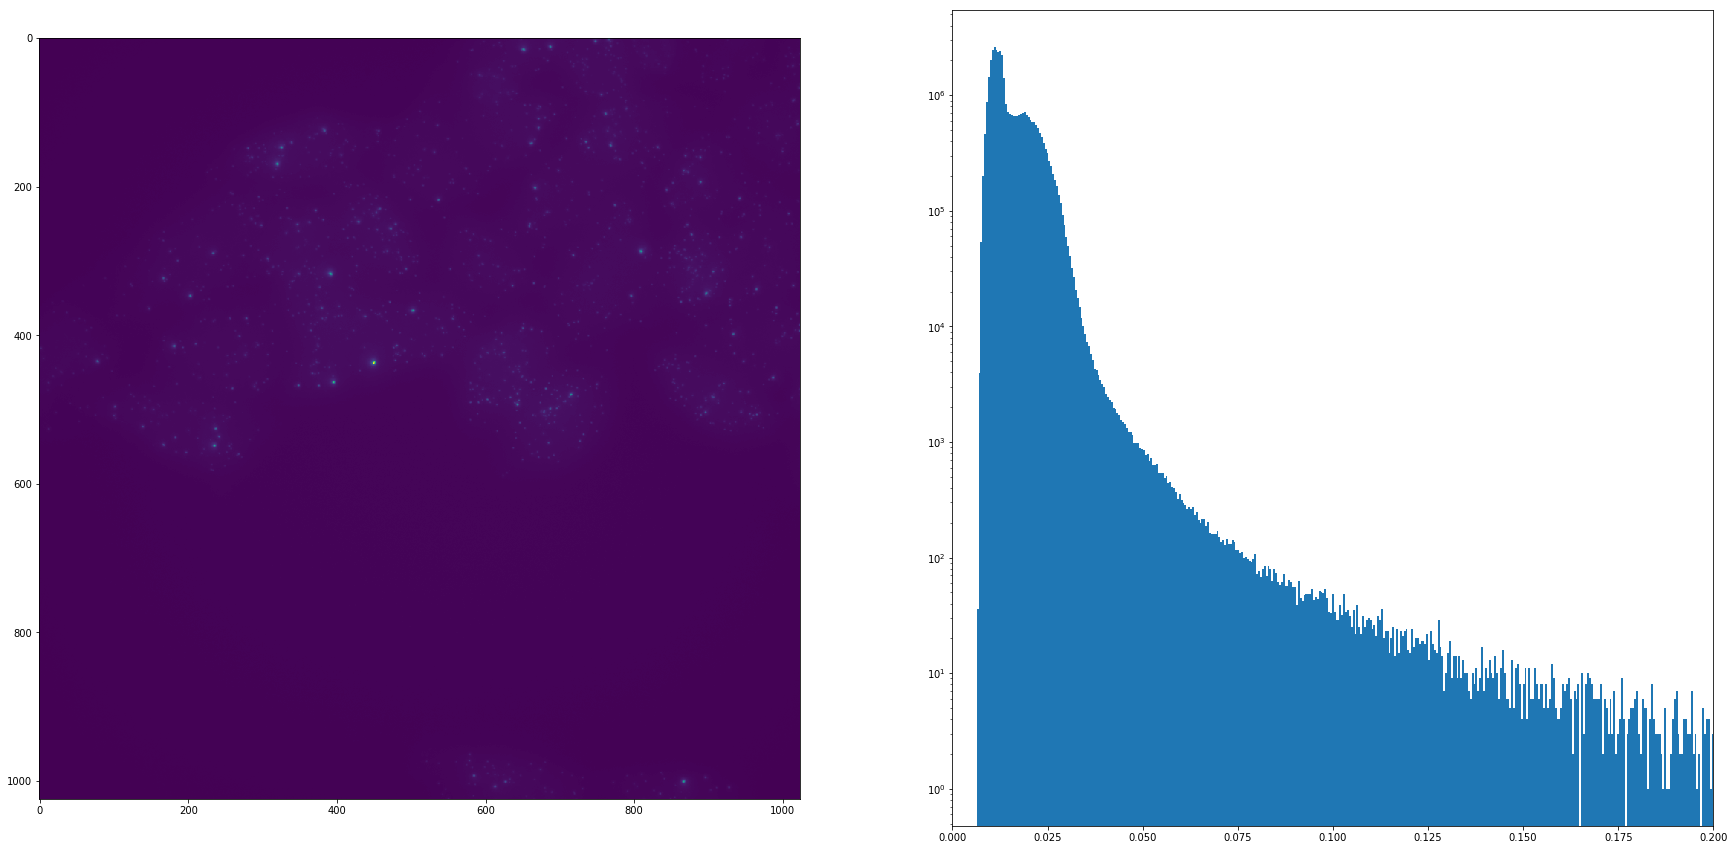

In [7]:
f, (ax0, ax1) = plt.subplots(ncols=2, figsize=(30, 15))
ax0.imshow(numpy.amax(raw, 2))
ax1.hist(numpy.log1p(raw.ravel()), bins=1000)
ax1.set_yscale('log')
ax1.set_xlim([0, 0.2])
f.show()


/Users/remydubois/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


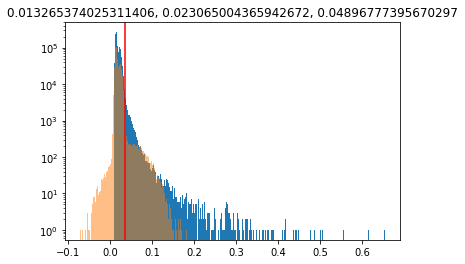

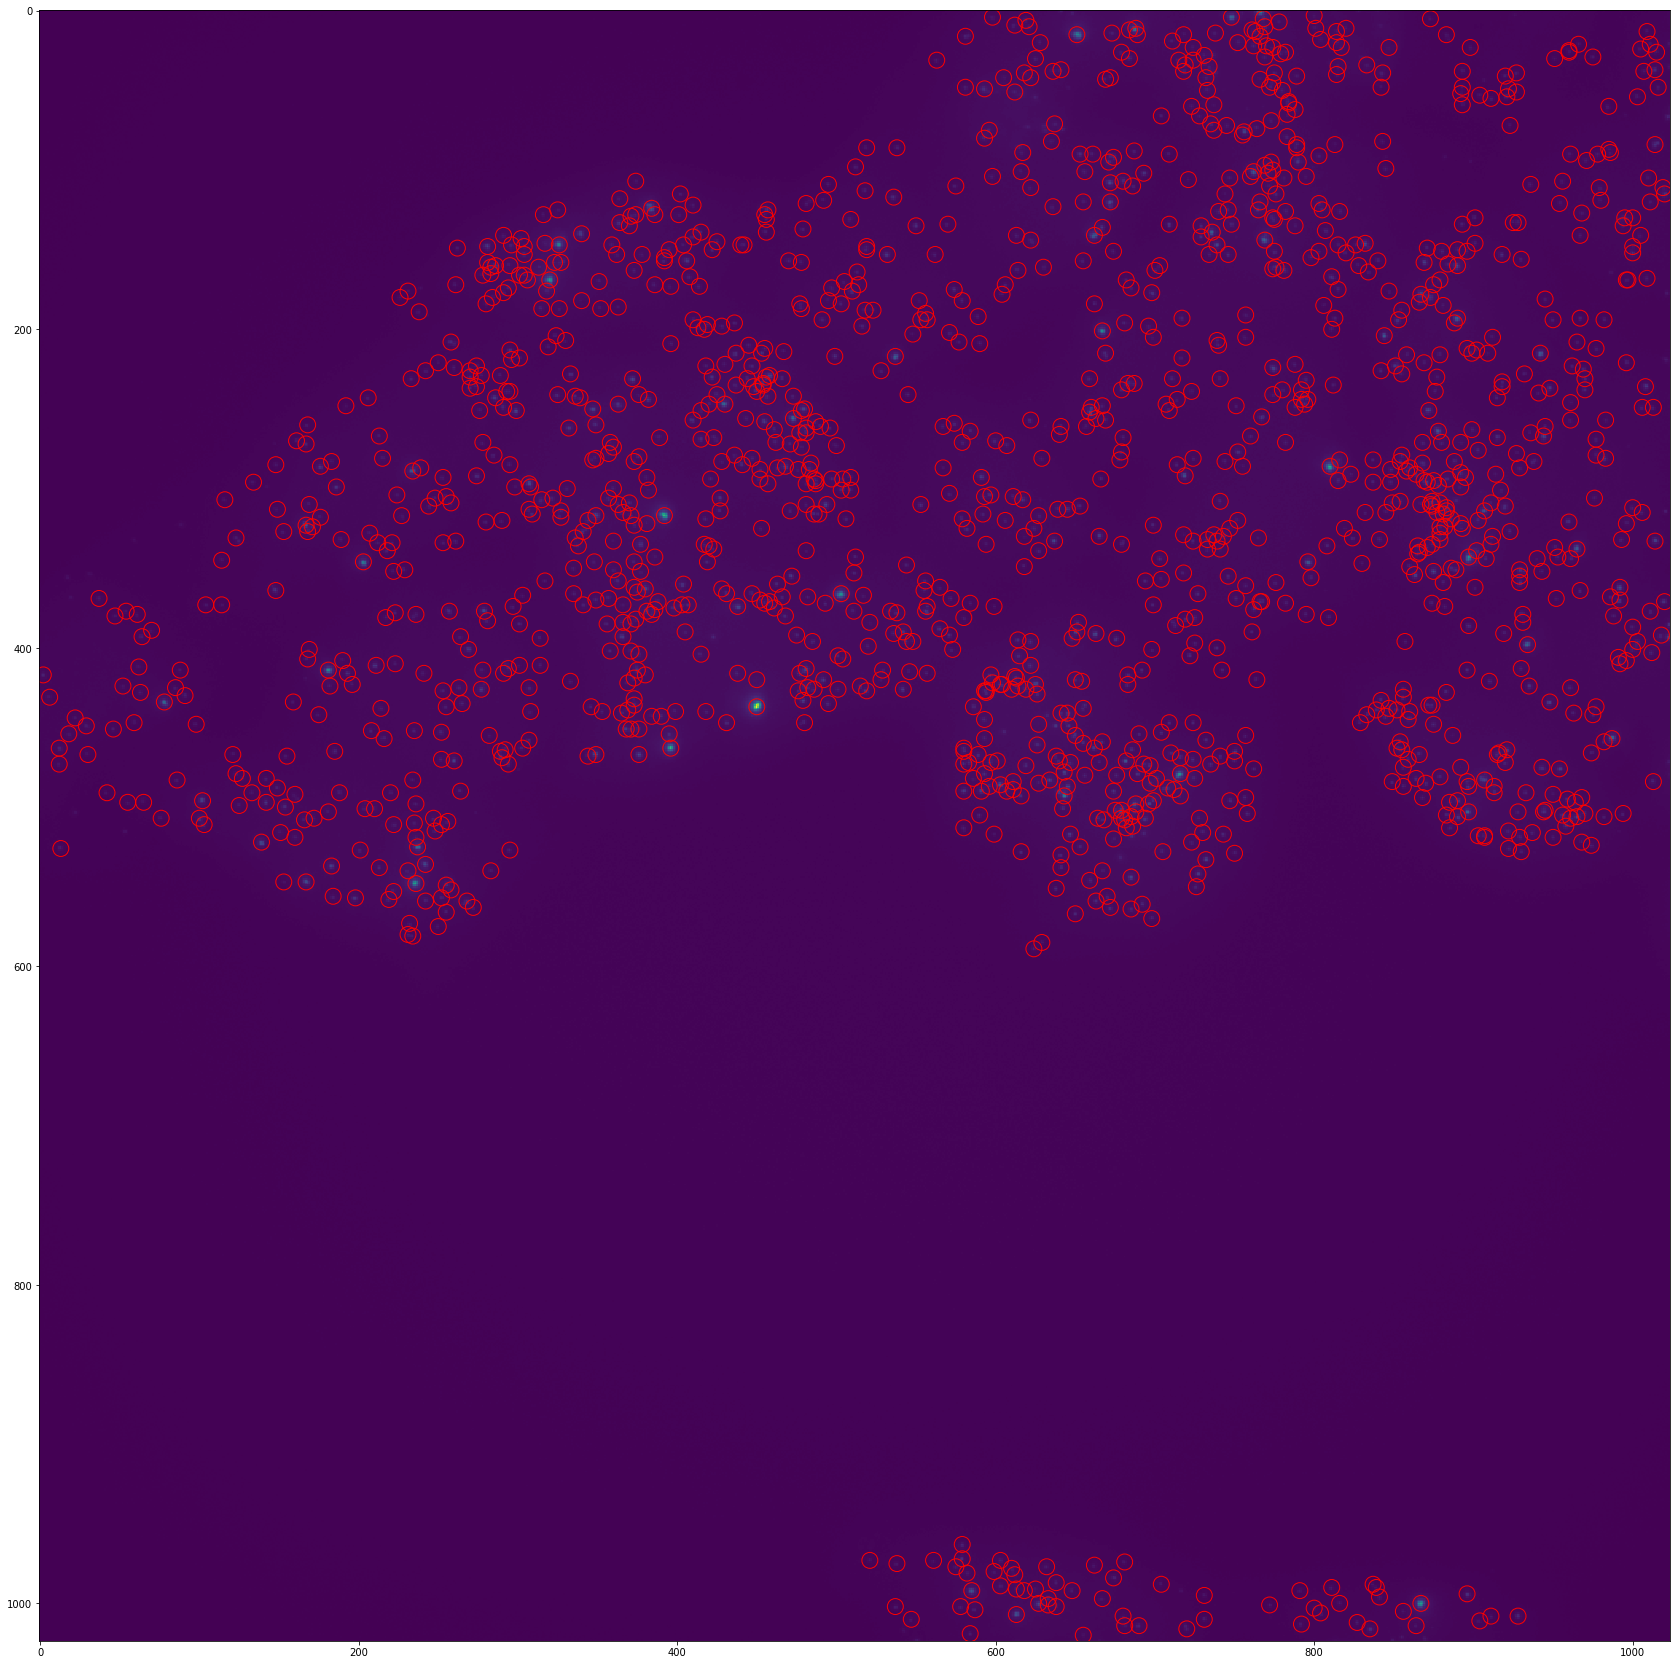

In [19]:
thresh = gmm_threshold(numpy.amax(raw, 2), 3, True)

# plt.imshow(numpy.amax(raw, 2))
peaks = peak_local_max(raw, footprint=numpy.ones((5, 5, 5)), threshold_abs=thresh)
f, ax = plt.subplots(figsize=(30, 30))
ax.imshow(numpy.amax(raw, 2))
for p in peaks:
    ax.add_patch(plt.Circle((p[1], p[0]), 5, fill=False, color='r'))
f.show()

In [38]:
image_cube = numpy.stack(dog_images, axis=-1)
inds_shapes = map(lambda p: numpy.argmax(image_cube[tuple(p)]), peaks)
shapes = [sigma_list[i] for i in inds_shapes]
blobs = numpy.hstack((peaks.astype(numpy.float64), numpy.array(shapes).reshape(-1, 1)))


/Users/remydubois/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 15 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


/Users/remydubois/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


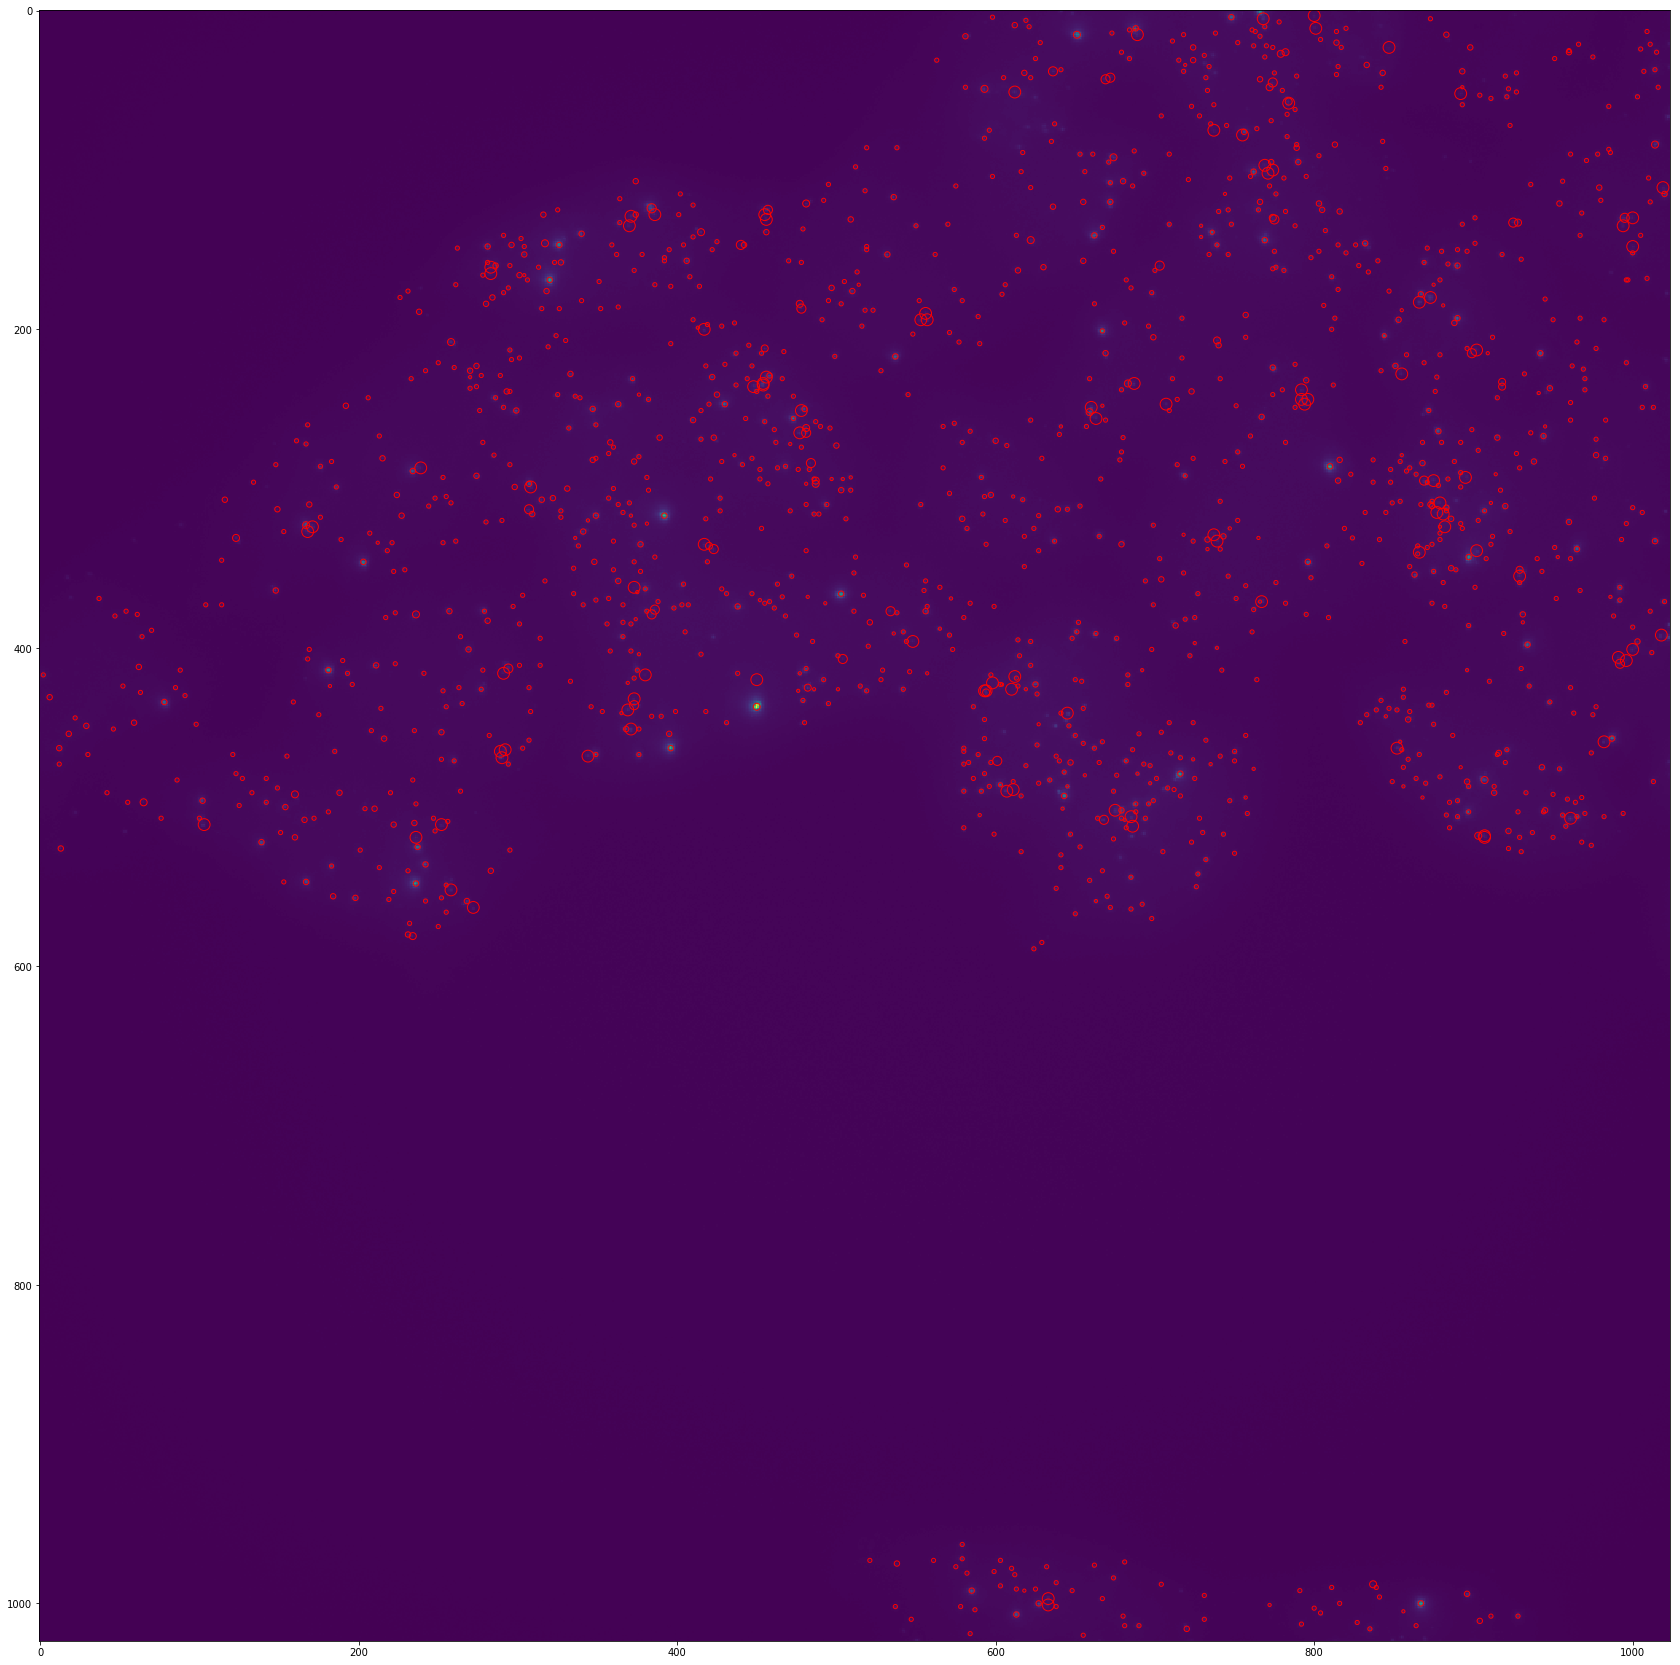

In [39]:
f, ax = plt.subplots(figsize=(30, 30))
background = rank.minimum(numpy.amax(im.image_raw, 2), disk(30))
clean = numpy.amax(im.image_raw, 2) - background
ax.imshow(numpy.amax(raw, 2))
for p in blobs:
    ax.add_patch(plt.Circle((p[1], p[0]), p[-1], fill=False, color='r'))
f.show()

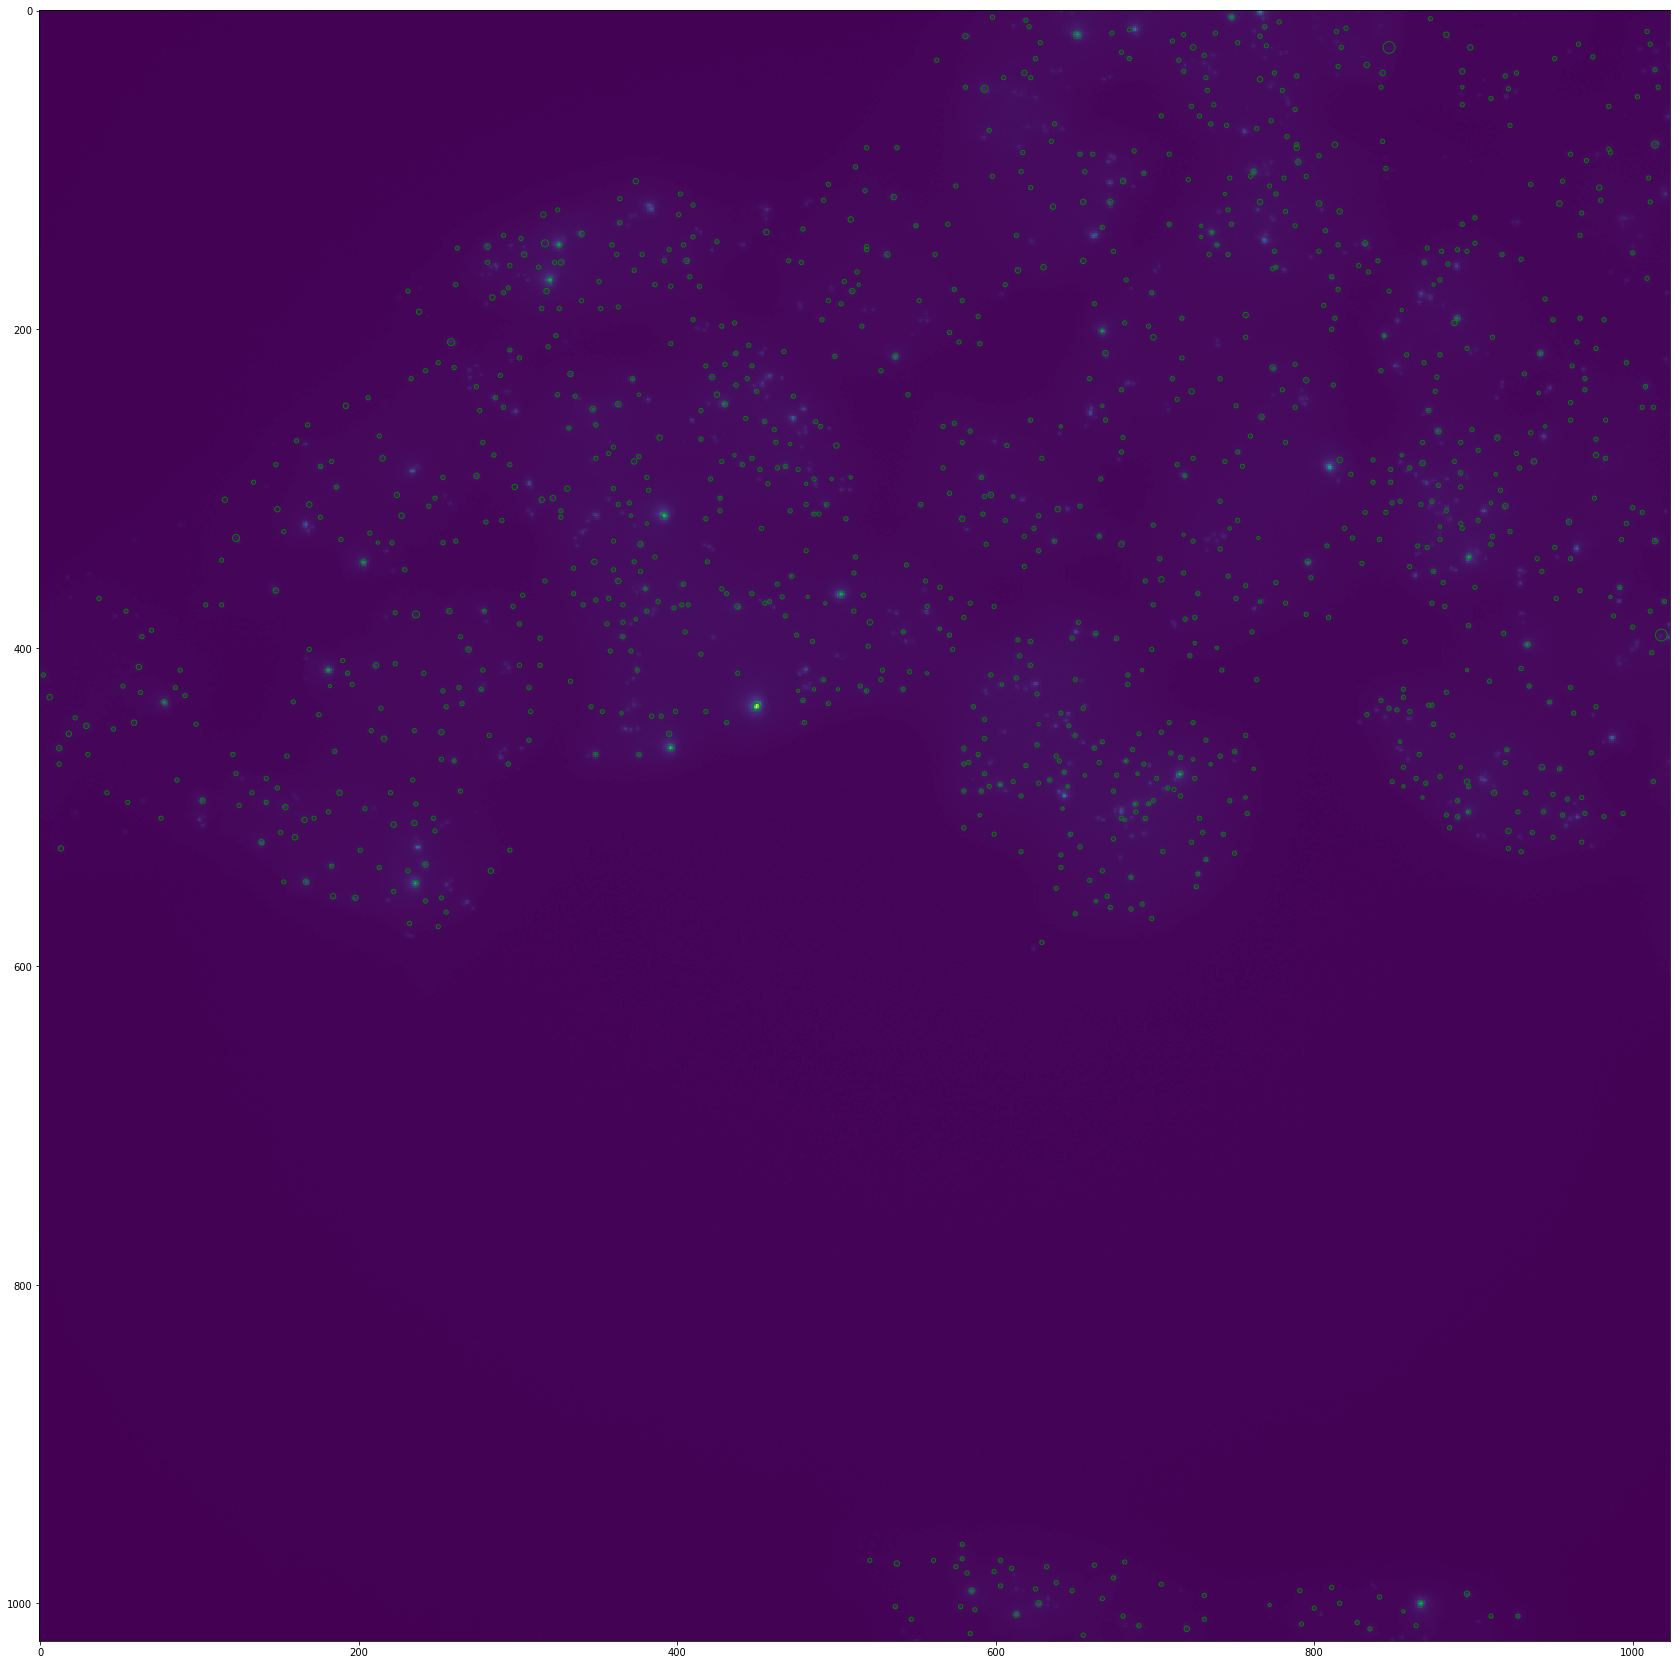

In [46]:
pruned_blobs = prune_blobs(blobs, overlap=0.)
f, ax = plt.subplots(figsize=(30, 30))
ax.imshow(numpy.amax(im.image_raw, 2))
for p in pruned_blobs:
    ax.add_patch(plt.Circle((p[1], p[0]), p[-1], fill=False, color='g'))



(7, 7, 7)


/Users/remydubois/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


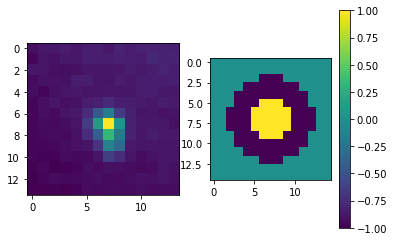

In [95]:
f, (ax1, ax2) = plt.subplots(ncols=2)
p = pruned_blobs[106]
widths = tuple([p[-1], ] * 3)
environment = im.image_raw[extract_cube(w, tuple(map(lambda x: 2 * 5 * x + 1, widths)))].copy()
center = tuple(min(p, w // 2) for (p, w) in zip(w, environment.shape))
print(center)
ax1.imshow(numpy.amax(im.image_raw, 2)[w[0] - 7:w[0] + 7, w[1] - 7:w[1] + 7])
mask_noise, mask_spot = ellipsis(tuple(map(lambda x: 2 * 2 * x, [p[-1], ] * 3)),
                                 environment.shape,
                                 center,
                                 hole_radius_ratio=1 / 2)
# print(mask_noise)

mask = numpy.zeros(environment.shape)
mask[mask_noise] = -1
mask[mask_spot] = 1
a = ax2.imshow(mask[:, :, 6])
f.colorbar(a)
f.show()
